In [9]:
from scipy.constants import pi 
from scipy.special import factorial
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite
import plotly.graph_objects as go

In [10]:
# Free parameters, typical setup for a HeNe laser (https://sites.astro.caltech.edu/~lah/ay105/pdf/Laser-Guide.pdf, page 8)

w_0 = 0.13 * 10**-3 # Beam waist (0.13 mm)
n = 1 # Refractive index of air
wavelength = 633 * 10**-9 # 633 nanometers (red light)
E_0 = 1 + 0j # E (V/m) some arbitrary value for visualization

k = 2 * pi * n / wavelength # Wave number

In [11]:
z_R = pi * w_0**2 * n / wavelength # Rayleigh range

def w(z):
    return w_0 * np.sqrt(1+ np.power(z/z_R, 2))

def R(z):
    # numerical stability at z=0
    if z == 0:
        return np.inf
    
    return z * (1 + (z_R/z)**2)


def E(x, y, z, l, m): # Returns a complex electric field value at (x,y,z) for mode (l,m)
    # Get Hermite polynomial functions for l and m
    H_l = hermite(l) 
    H_m = hermite(m)
    N = l+m
    
    u = np.sqrt(2) * x / w(z)
    v = np.sqrt(2) * y / w(z)
    
    real = E_0 * (w_0/w(z)) * H_l(u) * H_m(v) * np.exp(-(x**2 + y**2)/(w(z)**2))
    
    radial_phase = -k *(x**2 + y**2)/(2*R(z))
    longitudal_phase = -k*z
    gouy_phase = (N + 1) * np.arctan(z/z_R)

    phase = radial_phase + longitudal_phase + gouy_phase
    
    return real * np.exp(1j * phase) # Complex electric field

In [12]:
def superposition(x, y, z, modes):
    E_total = 0
    for (l, m, coeff) in modes:
        E_total += coeff * E(x, y, z, l, m) # Linear superposition of modes, weighted by coeffients
    return E_total


def intensity(x, y, z, modes):
    E_total = superposition(x, y, z, modes)
    return np.abs(E_total)**2 # Intensity is proportional to the square of the electric field amplitude (modulus squared for complex E)

In [13]:
z = 10 * w_0 # Observation plane at z=0
x = np.linspace(-3*w_0, 3*w_0, 400)
y = np.linspace(-3*w_0, 3*w_0, 400)
X, Y = np.meshgrid(x, y)

In [14]:
alpha = 0.5

def calculate_coherent_coeff(l):
    return np.exp(-0.5 * alpha**2) * (alpha**l) / np.sqrt(factorial(l))


modes_coherent = [(l, 0, calculate_coherent_coeff(l)) for l in range(50)] # Coherent state along x-axis, m=0

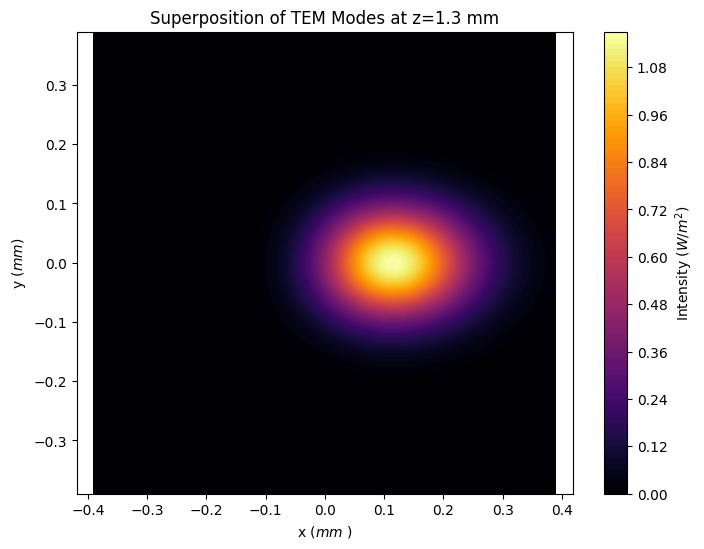

In [15]:
I_super = intensity(X, Y, z, modes_coherent)

# Matplotlib 2D Contour Plot
plt.figure(figsize=(8, 6))
plt.contourf(X*1e3, Y*1e3, I_super, levels=100, cmap='inferno') # Convert to mm for better visualization
plt.colorbar(label='Intensity ($W/m^2$)')
plt.title(f'Superposition of TEM Modes at z={z*1e3:.1f} mm')
plt.xlabel('x ($mm$ )')
plt.ylabel('y ($mm$)')
plt.axis('equal')
plt.show()

In [16]:
# 3D Surface Plot with Plotly
fig = go.Figure(data=[go.Surface(z=I_super, x=X*1e3, y=Y*1e3, colorscale='Inferno')])

# set colorbar title
fig.update_traces(colorbar_title='Intensity (W/m²)')

fig.update_layout(title=f'Superposition of TEM Modes at z={z*1e3:.1f} mm)',
                  scene = dict(
                      xaxis_title='X (mm)',
                      yaxis_title='Y (mm)',
                      zaxis_title='Intensity (W/m²)',
                      aspectratio=dict(x=1, y=1, z=0.5)),
                  width=800, height=800,
                  )  
fig.show()